In [ ]:
# UMAP script to reduce zircon geochemistry,
#2024-10-03 MAAZ
#2025-06-26, EBL

# input CG2024 dataset and select parameters (if not already input)
# run UMAP
# create decision boundary - linear SVC
# ROC_AUC curve calculation
# Plot global geochemistry in umap
# testing dataset: Nathwani2024
# input data in exact same format as CG2024 sheet
# apply trained scaler and UMAP model
# plot new data in original UMAP space


# Importing libraries and functions

In [1]:
import os
import numpy as np
import pandas as pd
import umap
import umap.plot
# import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import plotly.express as px #for plottly
import joblib #for saving UMAP model

from matplotlib import colors

#Machine learning libraries
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score

#Advanced plotting libraries
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
from bokeh.plotting import output_notebook #for interactive plot

#Script requirements
umap.plot.output_notebook() #resources= INLINE
%matplotlib inline
#%matplotlib widget #for 3d plot
sns.set_theme(style='white', context='notebook', rc={'figure.figsize':(14, 10)}) #anything smaller does not help with points

#Helper functions
def export_legend(legend, filepath2, expand=[-5,-5,5,5]):   

    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    
    fig.savefig(filepath2, dpi="figure", bbox_inches=bbox)

def make_dir(destDir):
    image_dir = destDir
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)  

Loading BokehJS ...

In [41]:
#User input - change directories 
data_folder1 = #SET DIRECTORY HERE!

file1 = "CG2024data_v3.csv"
file2 = "legend.png" #plot
file3 = "workable_table.xlsx" #for reproducibility
file4 = "standard_scaler.xml"
file5 = "umap_model.xml" 

trial_name = 'V3_zirconfertility' #IMPORTANT: change this name to avoid overwriting outputs


#Script begins

os.chdir(data_folder1)
print(data_folder1)

data_folder2 = os.path.join(os.path.dirname(data_folder1), 'outputs', trial_name)
make_dir(data_folder2)


filepath1 = os.path.join(data_folder1, file1)
filepath2 = os.path.join(data_folder2, file2)
filepath3 = os.path.join(data_folder2, file3)
filepath4 = os.path.join(data_folder2, file4)
filepath5 = os.path.join(data_folder2, file5)

#Load table (the column indexes below can be obtained from a data dictionary)
table1 = pd.read_csv(filepath1, low_memory=False)
table1.head()

range_imputed = list([0, 1, 2, 5, 6, 9, 10,11, 16, 18,105,106,63,36,37, 38, 39,65, 66, 67, 68, 69, 72, 74, 75, 76, 77,23,27,47,48])
#range_imputed.extend(list([65, 66, 67, 68, 69, 72, 74, 75, 76, 77]))
#range_imputed.extend(range(65, 77)) #imputed REE

range_imputed.extend(list([85,90,19,97,98,89,27,70,69,99]))

#Generating workable table
table2 = table1.iloc[:, range_imputed] 

#medicine 1
idx1 = table2.Temporality.isnull()
idx2 = table2["DepositBatholith"].isnull()
idx3 = table2["Sample"].isnull()
idx4 = table2["Continent"].isnull()
idx5 = table2["Composition"].isnull()
idx6 = table2["ID"].isnull()
idx7 = table2["District"].isnull()
idx8 = table2["U"].isnull()
idx9 = table2["Th"].isnull()
idx10 = table2["Ti"].isnull()
idx11 = table2["Hf"].isnull()
idx12 = table2["Zr_Age_Ma"].isnull()
idx13 = table2["Nb"].isnull()
idx14 = table2["Ta"].isnull()
idx15 = table2["Ce"].isnull()

table2.loc[idx1, "Temporality"] = 'Unknown'
table2.loc[idx2, "DepositBatholith"] = 'Unknown'
table2.loc[idx3, "Sample"] = 'Unknown'
table2.loc[idx4, "Continent"] = 'Unknown'
table2.loc[idx5, "Composition"] = 'Unknown'
table2.loc[idx6, "ID"] = 'Unknown'
table2.loc[idx7, "District"] = 'Unknown'
table2.loc[idx8, "U"] = 0
table2.loc[idx9, "Th"] = 0
table2.loc[idx10, "Ti"] = 0
table2.loc[idx11, "Hf"] = 0
table2.loc[idx12, "Zr_Age_Ma"] = 0
table2.loc[idx13, "Nb"] = 0
table2.loc[idx14, "Ta"] = 0
table2.loc[idx15, "Ce"] = 0


#Dropping rows with empty cells

#medicine 2: do not drop string NAs
any_idx = table2.isna().any(axis=1)
table3 = table2.loc[np.invert(any_idx), :] # np.invert(any_idx)
table3.reset_index(inplace = True) #the index from the input table is preserved (for searching points)

data_start_idx = 32 #10
col_names = list(table3.columns)
a = table2.shape[0]
b = table3.shape[0]
c = col_names[data_start_idx:]

print(f"Table 2 has {a} rows and Table 3 without NA has {b} rows")
print(f"UMAP will use: {c}")
table3.head()
table3.tail()

C:\Users\n11554070\OneDrive - Queensland University of Technology\Documents\Zircon Geochemistry DB\Test Script 2\V3_zirconfertility\trials
Table 2 has 21687 rows and Table 3 without NA has 20477 rows
UMAP will use: ['Eu/Eu*', 'λ3', 'P', 'Dy/Yb', 'Ce/Nd', 'λ2', 'Eu', 'Imputed_Tb', 'Imputed_Gd', 'Gd/Yb']


,index,ml_classes,setID,Dataset,District,DepositBatholith,Temporality,ID,Sample,Composition,...,Eu/Eu*,λ3,P,Dy/Yb,Ce/Nd,λ2,Eu,Imputed_Tb,Imputed_Gd,Gd/Yb
20472,21682,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.030768,-12.797884,746.814522,0.458291,6.634620,-259.913051,0.497971,40.99687,103.12050,0.101007
20473,21683,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.020427,55.685745,348.195636,0.323132,2.795629,-198.171602,0.191126,25.02194,68.24490,0.073751
20474,21684,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.043703,26.558059,339.226115,0.343586,3.645443,-206.510013,0.372821,22.76995,57.66838,0.072188
20475,21685,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.026781,2.476461,330.955483,0.316685,3.686136,-205.224423,0.264009,23.53614,62.41033,0.065524
20476,21686,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.030398,44.643797,445.009769,0.337480,2.431174,-189.190048,0.421760,32.73404,87.11800,0.075397


# Loading and filtering data

## Printing populations for each category

In [43]:
categoricals = ["ml_classes", "setID", "Dataset", "District", "DepositBatholith", "Temporality", "ID", "Sample", "Composition", "Continent", "Zr_Age_Ma"]
for i in range(len(categoricals)):
    temp = table3.loc[:, [categoricals[i]]].value_counts()
    print(temp)

#table3.loc[:, [categoricals[1]]].value_counts()

ml_classes
Barren        13192
Fertile        7285
Name: count, dtype: int64
setID     
main          18393
validation     2084
Name: count, dtype: int64
Dataset
River      6753
Deposit    6232
GeoRoc     4629
Unknown    2084
Barren      779
Name: count, dtype: int64
District                                   
Unknown                                        13466
Yerington                                       2273
Northwestern Argentina                           952
El Abra-Chuquicamata intrusive cluster           813
Eastern Sunda arc Sumbawa                        609
Centinela District                               464
Eocene Wasatch igneous belt Utah                 323
Escondida District                               277
Papua province eastern Indonesia                 259
S-type Granite                                   172
S-I Granites                                     143
Papua New Guinea                                 129
Central-West New South Wales                     124

# Embedding space
### Run only once each time the notebook is opened. The stochastic process within UMAP wont repeat itself for all plots otherwise

Generating and saving model

In [ ]:
# run UMAP IF not using UMAP model and saved scaler from file, if these have been created already, run the cell below instead

try:
    del embedding
except:
    print('Processing for the first time')

components_output = 2 #default=2, dimensionality
neighbors_input = 20 #default=15, preservation of local (> singletons) vs global structure
min_dist_input = 0.003 #0.003, min. dist. of packing value (in low dimensional representation)

#data
data = table3.iloc[:, data_start_idx:].values
sc = StandardScaler()
scaled_data = sc.fit_transform(data) 
#print("Scaler mean: ", sc.mean_)
#print("Scaler scale: ", sc.scale_)

#umap object () for umap.plot
embedding = umap.UMAP(n_neighbors= neighbors_input,
                      min_dist= min_dist_input,
                      metric='correlation', 
                      n_components= components_output,
                     ).fit(scaled_data)  

#Saving data for reproducibility
table3.to_excel(filepath3, index=False) #processed table
joblib.dump(sc, filepath4) #scaler
joblib.dump(embedding, filepath5) #umap transform

In [49]:
# run this IF using the saved scaler and UMAP transform from file, OR after running cell above

sc = joblib.load(filepath4) #scaler
embedding = joblib.load(filepath5) #umap transformation

embedding2 = embedding.embedding_

#Load table 
table3 = pd.read_excel(filepath3)
table3.tail()

<class 'umap.umap_.UMAP'>
UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.003, n_neighbors=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


,index,ml_classes,setID,Dataset,District,DepositBatholith,Temporality,ID,Sample,Composition,...,Eu/Eu*,λ3,P,Dy/Yb,Ce/Nd,λ2,Eu.1,Imputed_Tb,Imputed_Gd.1,Gd/Yb
20472,21682,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.030768,-12.797884,746.814522,0.458291,6.634620,-259.913051,0.497971,40.99687,103.12050,0.101007
20473,21683,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.020427,55.685745,348.195636,0.323132,2.795629,-198.171602,0.191126,25.02194,68.24490,0.073751
20474,21684,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.043703,26.558059,339.226115,0.343586,3.645443,-206.510013,0.372821,22.76995,57.66838,0.072188
20475,21685,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.026781,2.476461,330.955483,0.316685,3.686136,-205.224423,0.264009,23.53614,62.41033,0.065524
20476,21686,Barren,validation,Unknown,Unknown,Whichita,Unknown,Unknown,WP18-1,Unknown,...,0.030398,44.643797,445.009769,0.337480,2.431174,-189.190048,0.421760,32.73404,87.11800,0.075397


In [19]:
# enter variable below

variable_legend = "ml_classes" #e.g., Temporality, ml_classes

list_unique = table3[variable_legend].unique()
n_classes = len(list_unique)

#colourmap
mapping = {item:i for i, item in enumerate(list_unique)}
classif= table3[variable_legend].apply(lambda x: mapping[x]) #categorical array (same size as table3)
colourmap = sns.color_palette(palette= cc.glasbey_category10, n_colors = n_classes)
colours = [sns.color_palette(palette= colourmap)[x] for x in classif] #RGB triplets

colourmap_updated = colourmap #pre-allocating
for x in range(0, n_classes):
    
    idx = (classif == x)
    name = list_unique[x]

    colours_sub = colourmap[x]
    
    if name == 'Ore syn-mineral magmatism':
        colours_sub = colors.to_rgb('red')

    if name == 'Syn Mineral':
        colours_sub = colors.to_rgb('red')

    if name == 'Ore related magmatism':
        target_colour = (255, 208, 0)
        colours_sub = tuple(ti/255 for ti in target_colour)

    if name == 'Unknown':
        colours_sub = colors.to_rgb('lightgrey')

    if name == 'S Type Granite':
        colours_sub = colors.to_rgb('violet')

    colourmap_updated[x] = colours_sub

In [21]:
# enter variable to be used as known labels for binary classification

variable_legend = "ml_classes" #Temporality

#medicine 3
if variable_legend == "Deposit/Batholith":
    variable_legend1 = "Deposit-Batholith"
else:
    variable_legend1 = variable_legend
    

list_unique = table3[variable_legend].unique()
n_classes = len(list_unique)

#colourmap
mapping = {item:i for i, item in enumerate(list_unique)}
classif= table3[variable_legend].apply(lambda x: mapping[x]) #categorical array (same size as table3)

#panda series
df = pd.DataFrame( dict(x=embedding2[:,0], y=embedding2[:,1], z= classif) ) 
X = df.iloc[:, 0:2].to_numpy()
Y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [23]:
# binary decision plane using linear SVC, performance scores of binary model

clf = SVC(kernel="linear", C=0.025, random_state=42, probability= True) #C = 1 (regularisation)

clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test) #mean accuracy 

 # Predict using the best model
best_model = clf #if cross-validation: .best_estimator_
pred = best_model.predict(X_test)
ac = balanced_accuracy_score(y_test, pred) # same as 'score'
f1_ = f1_score(y_test, pred) # F1 scores

# Receiver operating characteristic (ROC) area under the curve (AUC)
probs = best_model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_ = auc(fpr, tpr)

print("=== Nested K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(ac), 3)))
print("Mean F1: "+ str(round(np.mean(f1_), 3)))
print("Mean roc_auc: "+ str(round(np.mean(auc_), 3)))


=== Nested K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.864
Mean F1: 0.823
Mean roc_auc: 0.927


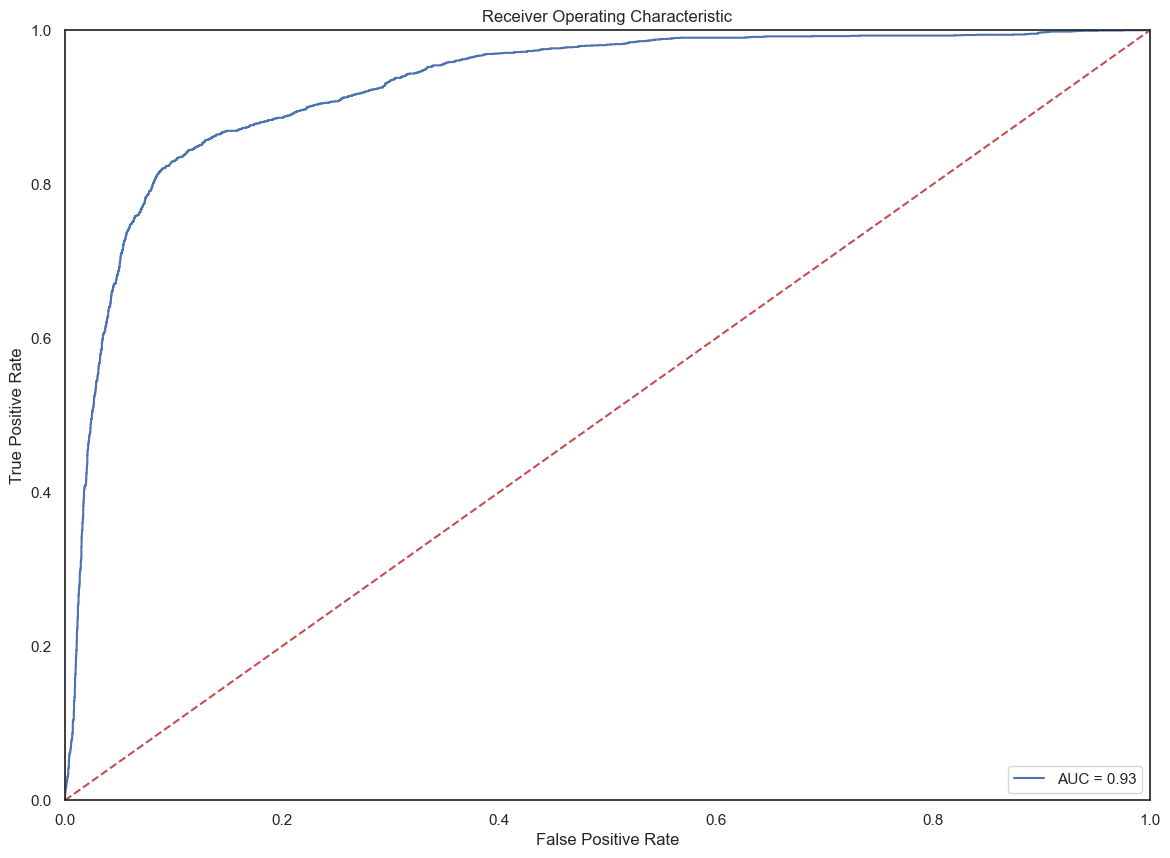

In [25]:
# plotting ROC_AUC

probs = best_model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_ = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

C:\Users\n11554070\OneDrive - Queensland University of Technology\Documents\Zircon Geochemistry DB\Test Script 2\V3_zirconfertility\outputs\V3_zirconfertility\ml_classes_plot.png


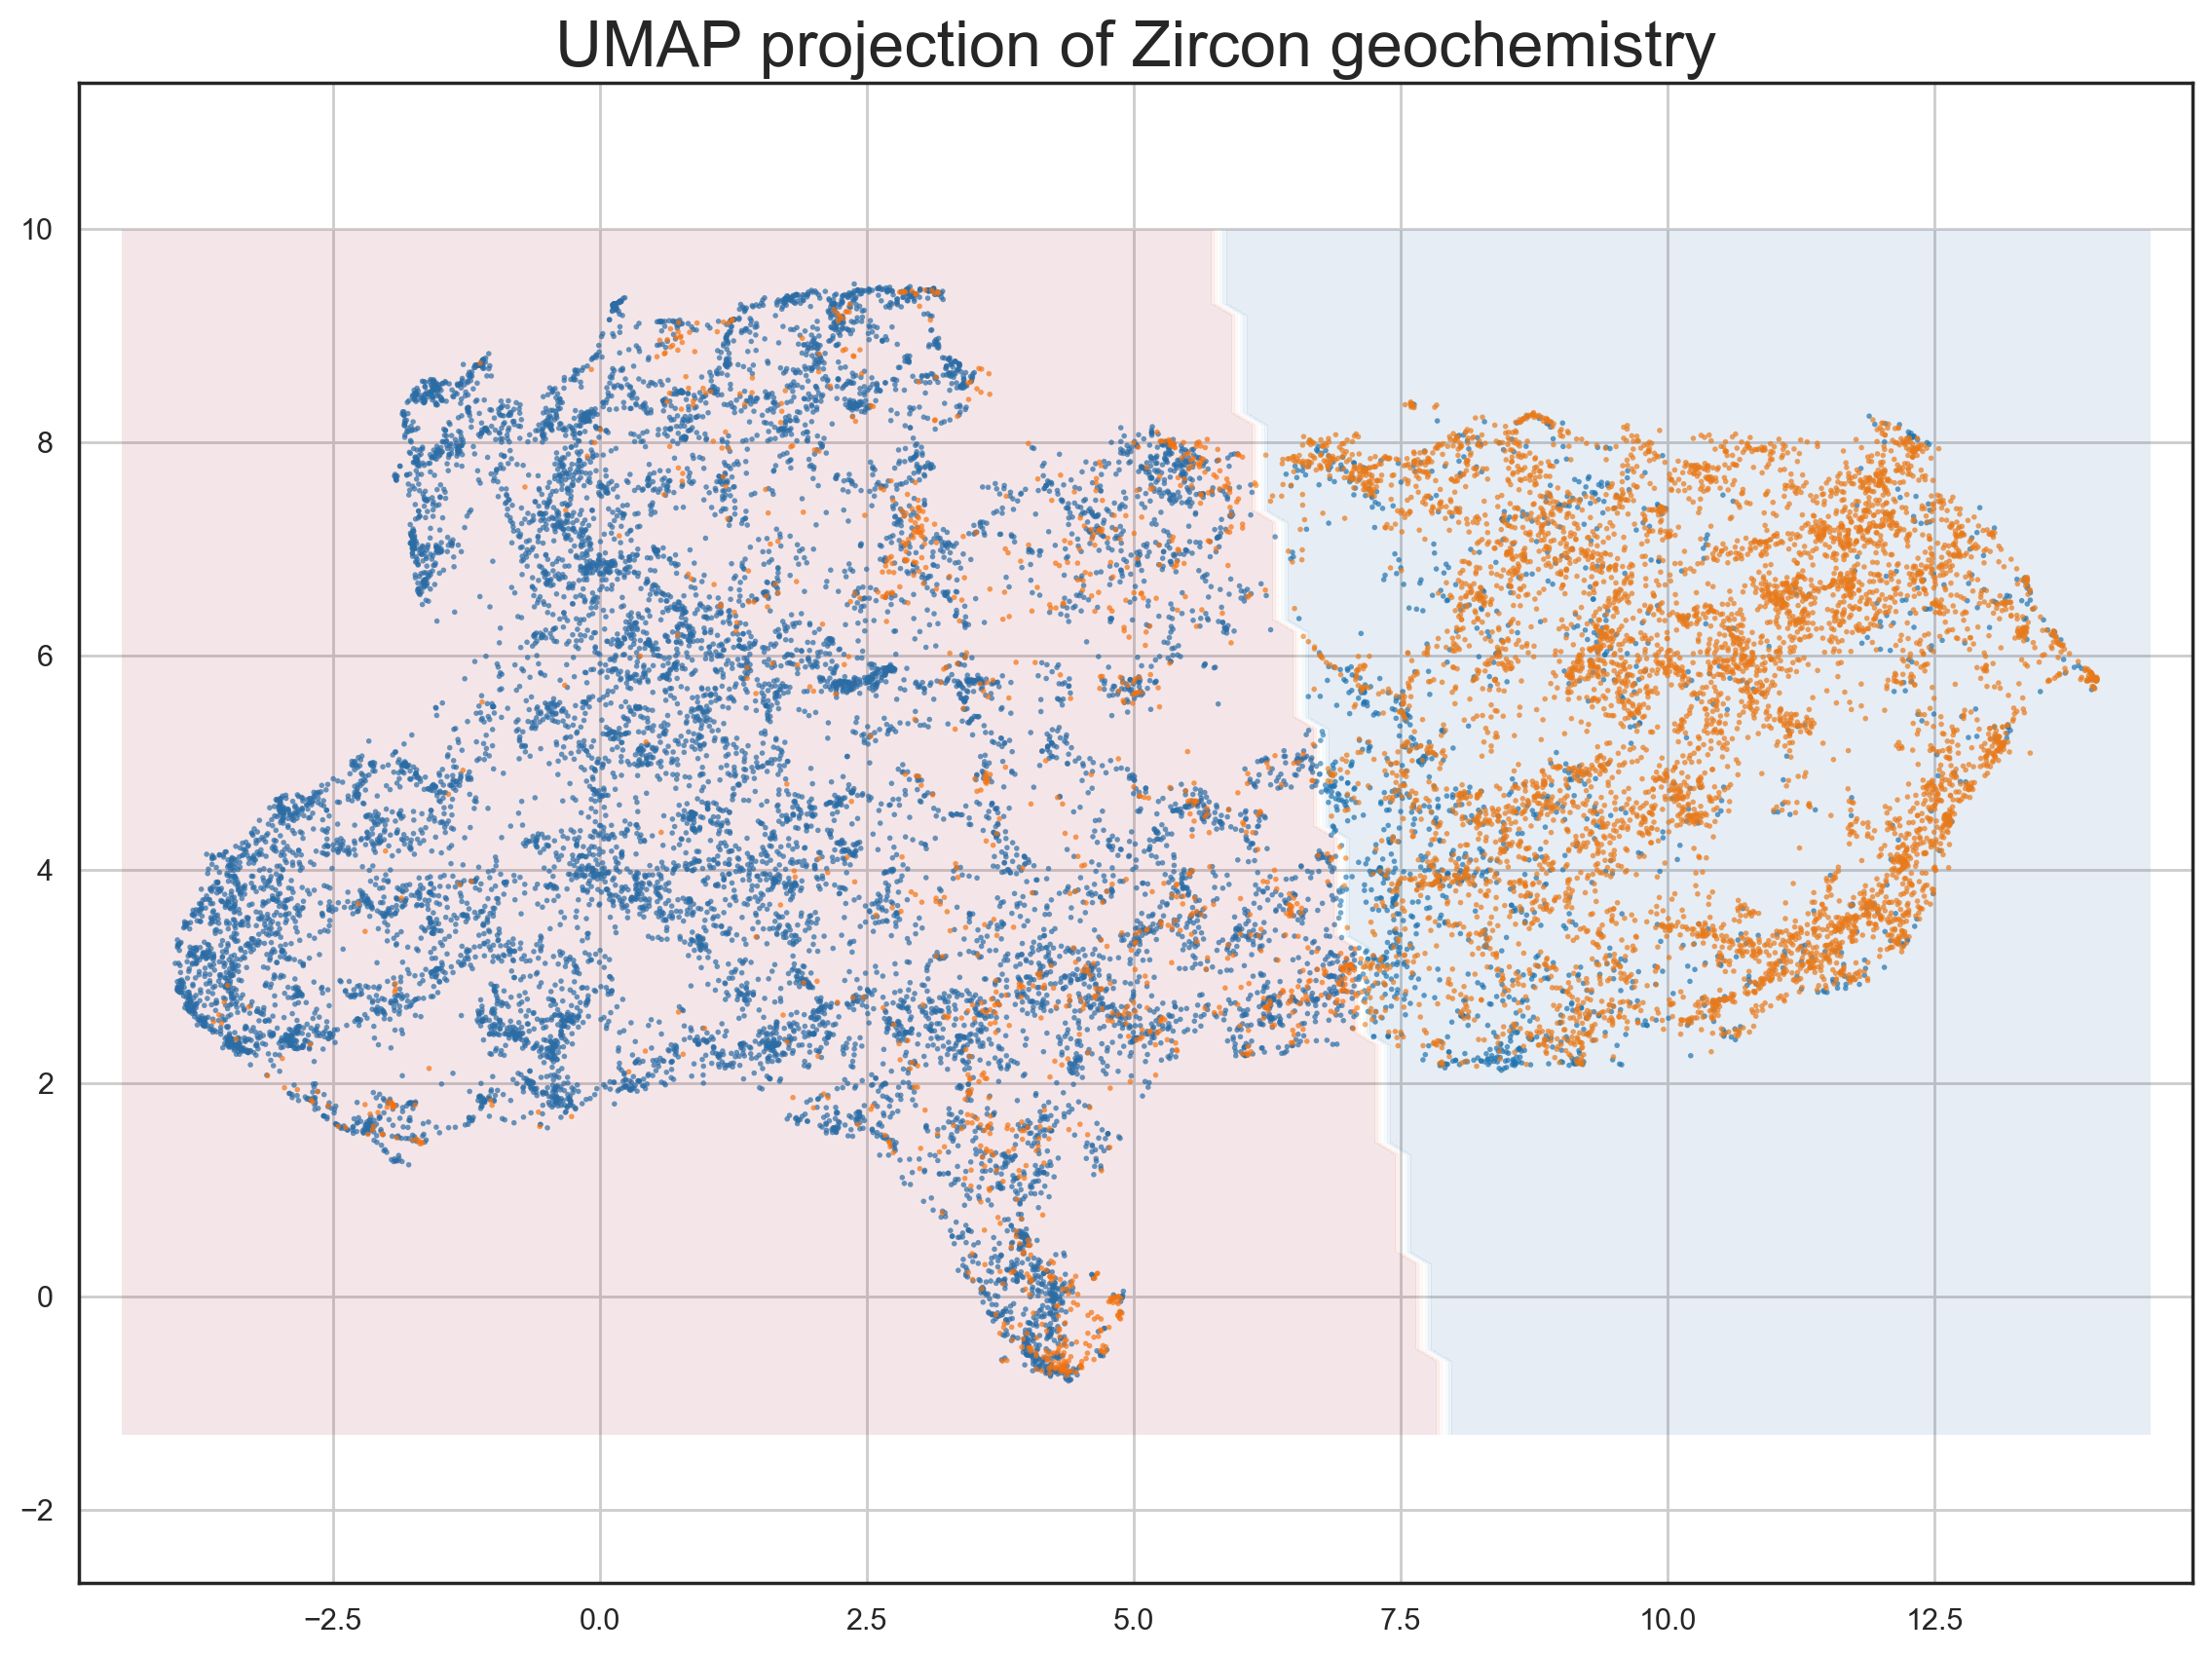

In [27]:
# plot global projection of zircon geochemistry from CG2024

#Saving names
filepath3_new = filepath2.replace("legend.png", variable_legend1 + "_legend.png")
filepath4_new = filepath2.replace("legend.png", variable_legend1 + "_plot.png")
print(filepath4_new)

#Plot
markerSize = 4
fontSize = 18

fig = plt.figure(dpi= 200) #1200 , figsize=(10, 10)

for x in range(0, n_classes):

    
    idx = (classif == x)
    name = list_unique[x]
   
    # colours_sub = list(compress(colours, idx)) #required to index list
    colours_sub = np.asarray(colourmap_updated[x]).reshape(1,-1)        
    
    scatter = plt.scatter(embedding2[idx, 0], embedding2[idx, 1],
                              c=colours_sub, label = name,
                              s= markerSize, alpha= .7, edgecolors= 'none')


# #Wiggles (new plots)
plt.autoscale(False)
# # plt.plot(xx, yy, 'k-') #linear
# plt.contour(xx, yy, Z, cmap=plt.cm.Paired) #multi-class

#Generic
ax = plt.gca()
cm = plt.cm.RdBu

#Try this 3 options (commenting them if either of them fail)
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.1, ax=ax, eps=.5, response_method='predict') #area with colours following predicted classes (if ignoring 'cm')


#Settings
plt.grid(True)
plt.gca().set_aspect('equal', 'datalim')

plt.title('UMAP projection of Zircon geochemistry', fontsize=24)

lgnd = plt.legend(ncol=1, fontsize= fontSize, loc='center right', bbox_to_anchor=(1.4, 0.5),
                  markerscale= 10, scatterpoints=1)
export_legend(lgnd, filepath2= filepath3_new)
lgnd.remove()
plt.show()

fig.savefig(filepath4_new, dpi="figure")
            

In [ ]:
# Testing unknown data , required identical input format to the original CD2024 table

In [35]:
#load testing dataset in exact format as global database - here use Test_Nathwani2024

test1 = pd.read_csv("Test_Nathwani2024.csv")
test1.head()

range_imputed = list([0, 1, 2, 5, 6, 9, 10,11, 16, 18,86,106,36, 38, 39,65, 66, 67, 68, 69, 72, 74, 75, 76, 77,23,27,47,48])
#range_imputed.extend(list([65, 66, 67, 68, 69, 72, 74, 75, 76, 77]))
#range_imputed.extend(range(65, 77)) #imputed REE

range_imputed.extend(list([85,90,19,97,98,89,27,70,69,99]))

#Generating workable table
test2 = test1.iloc[:, range_imputed] 

#medicine 1
idx1 = test2.Temporality.isnull()
idx2 = test2["DepositBatholith"].isnull()
idx3 = test2["Sample"].isnull()
idx4 = test2["Continent"].isnull()
idx5 = test2["Composition"].isnull()
idx6 = test2["ID"].isnull()
idx7 = test2["District"].isnull()
#idx8 = test2["U"].isnull()
idx9 = test2["Th"].isnull()
idx10 = test2["Ti"].isnull()
idx11 = test2["Hf"].isnull()
idx13 = test2["Nb"].isnull()
idx14 = test2["Ta"].isnull()
idx15 = test2["Ce"].isnull()

test2.loc[idx1, "Temporality"] = 'Unknown'
test2.loc[idx2, "DepositBatholith"] = 'Unknown'
test2.loc[idx3, "Sample"] = 'Unknown'
test2.loc[idx4, "Continent"] = 'Unknown'
test2.loc[idx5, "Composition"] = 'Unknown'
test2.loc[idx6, "ID"] = 'Unknown'
test2.loc[idx7, "District"] = 'Unknown'
#test2.loc[idx8, "U"] = 0
test2.loc[idx9, "Th"] = 0
test2.loc[idx10, "Ti"] = 0
test2.loc[idx11, "Hf"] = 0
test2.loc[idx13, "Nb"] = 0
test2.loc[idx14, "Ta"] = 0
test2.loc[idx15, "Ce"] = 0


#Dropping rows with empty cells

#medicine 2: do not drop string NAs
any_idx = test2.isna().any(axis=1)
test3 = test2.loc[np.invert(any_idx), :] # np.invert(any_idx)
test2.reset_index(inplace = True) #the index from the input table is preserved (for searching points)

data_start_idx = 29 #10
col_names = list(table3.columns)
a = test2.shape[0]
b = test3.shape[0]
c = col_names[data_start_idx:]

print(f"Table 2 has {a} rows and Table 3 without NA has {b} rows")
print(f"UMAP will use: {c}")
test3.head()
test3.tail()

Table 2 has 1371 rows and Table 3 without NA has 984 rows
UMAP will use: ['Eu', 'Nb', 'Ta', 'Eu/Eu*', 'λ3', 'P', 'Dy/Yb', 'Ce/Nd', 'λ2', 'Eu.1', 'Imputed_Tb', 'Imputed_Gd.1', 'Gd/Yb']


,ml_classes,setID,Dataset,District,DepositBatholith,Temporality,ID,Sample,Composition,Continent,...,Eu/Eu*,λ3,P,Dy/Yb,Ce/Nd,λ2,Eu,Imputed_Tb,Imputed_Gd,Gd/Yb
979,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.071777,11.287587,245.1,0.284733,4.913043,-115.606192,0.180,5.51,17.15,0.069265
980,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.087327,50.970223,308.3,0.312525,4.334140,-116.213361,0.496,12.67,39.10,0.077734
981,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.092603,0.886639,120.1,0.217516,11.315789,-90.042249,0.087,2.32,6.82,0.048959
982,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.144536,-33.744431,161.3,0.275000,7.274194,-128.856744,0.166,2.57,7.79,0.064917
983,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.073965,93.117521,239.0,0.290074,5.771144,-110.236858,0.198,6.38,19.60,0.072059


In [37]:
#Applying UMAP transform to new data 

data = test3.iloc[:, data_start_idx:].values
scaled_data = sc.transform(data) 

test_embedding = embedding.transform(scaled_data)

test3.tail()


,ml_classes,setID,Dataset,District,DepositBatholith,Temporality,ID,Sample,Composition,Continent,...,Eu/Eu*,λ3,P,Dy/Yb,Ce/Nd,λ2,Eu,Imputed_Tb,Imputed_Gd,Gd/Yb
979,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.071777,11.287587,245.1,0.284733,4.913043,-115.606192,0.180,5.51,17.15,0.069265
980,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.087327,50.970223,308.3,0.312525,4.334140,-116.213361,0.496,12.67,39.10,0.077734
981,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.092603,0.886639,120.1,0.217516,11.315789,-90.042249,0.087,2.32,6.82,0.048959
982,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.144536,-33.744431,161.3,0.275000,7.274194,-128.856744,0.166,2.57,7.79,0.064917
983,Barren,main,Barren,Rio Blanco-Los Bronces,W El Cruce,Batholith,WEC01,San Francisco Batholith,unk,SA,...,0.073965,93.117521,239.0,0.290074,5.771144,-110.236858,0.198,6.38,19.60,0.072059


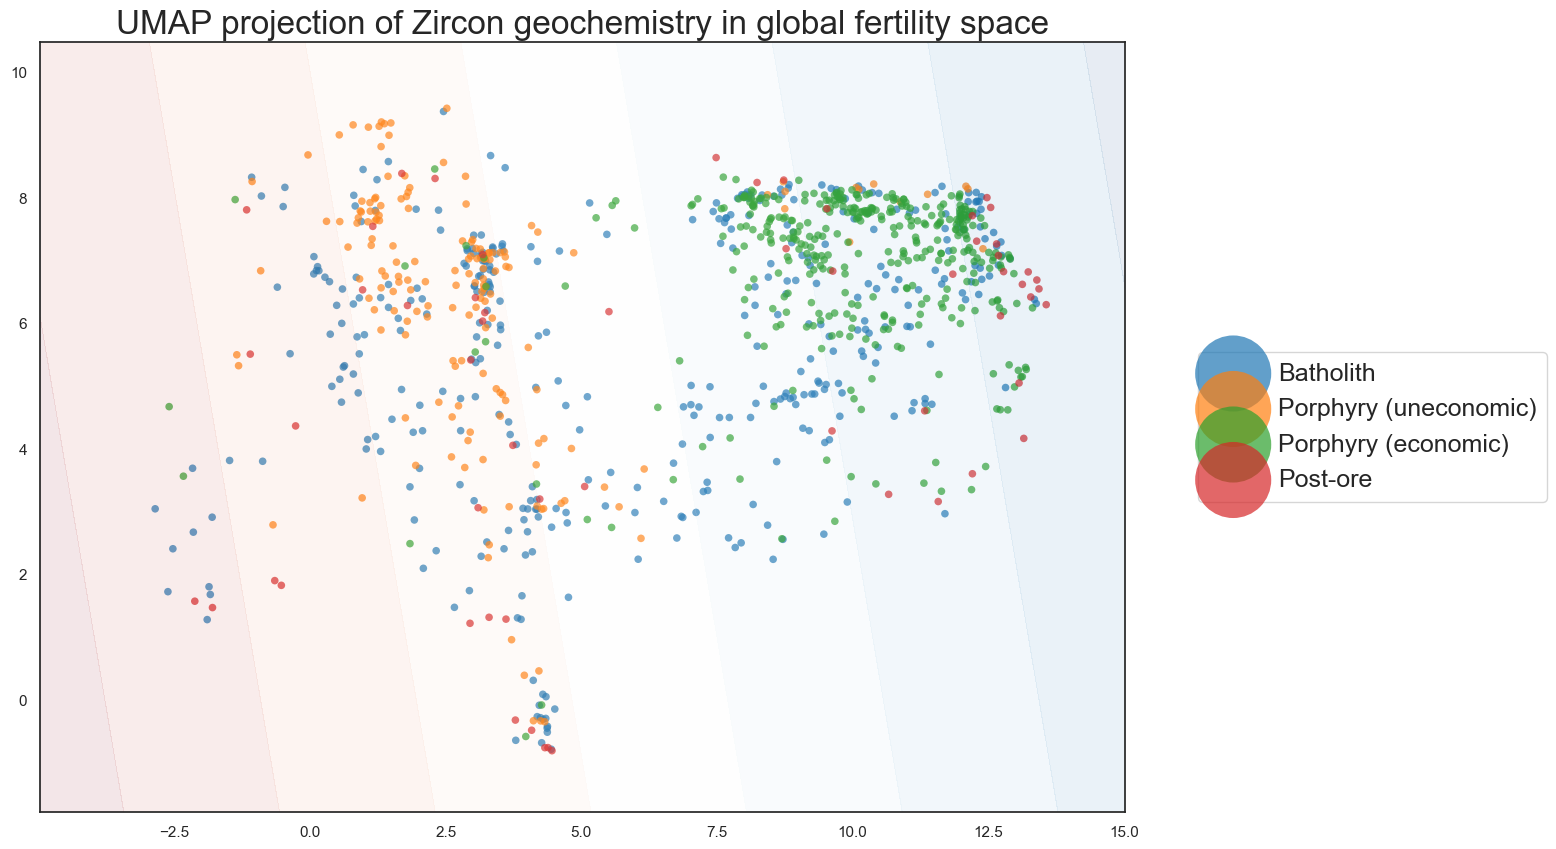

In [39]:
# plot testing data projected into global fertility space

variable_legend = "Temporality"

list_unique = test3[variable_legend].unique()
n_classes = len(list_unique)

mapping = {item:i for i, item in enumerate(list_unique)}
classif= test3[variable_legend].apply(lambda x: mapping[x])
colours = [sns.color_palette(palette= cc.glasbey_category10, n_colors = n_classes)[x] for x in classif]

markerSize = 30
fontSize = 18

for x in range(0, n_classes):
    idx = (classif == x)
    name = list_unique[x]
    colours_sub = list(compress(colours, idx))   

    scatter = plt.scatter(test_embedding[idx, 0], test_embedding[idx, 1],
                            c=colours_sub, label = name,
                            s= markerSize, alpha= .7, edgecolors= 'none')


lgnd = plt.legend(ncol=1, fontsize= fontSize, loc='center right', bbox_to_anchor=(1.4, 0.5),
                  markerscale= 10, scatterpoints=1)

ax = plt.gca()
cm = plt.cm.RdBu
plt.title('UMAP projection of Zircon geochemistry in global fertility space', fontsize=24)

DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, plot_method='contourf',  alpha=0.1, ax=ax, response_method="decision_function")

